### Same as Untitled8 but this is for G20, not DvH!!!

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

'''
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
%Rdevice svg
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf
'''
None

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Dont forget to mount the data drive -- udisks --mount /dev/sdb1

In [ ]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [8]:
sample_info = pd.read_excel('Sample_Info_FIXED2.xlsx') ##,skiprows=[0])
sample_info = sample_info.drop( ['growth rate per h (OLD)', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Sample name.1'], 1)
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
print sample_infos.keys()
info = sample_infos['Desulfovibrio_alaskensis_G20_uid57941'].copy()
sizeme(info.head(3),50,120)

['Desulfovibrio_alaskensis_G20_uid57941', 'Methanospirillum_hungatei_JF_1_uid58181', 'Methanococcus_maripaludis_S2_uid58035', 'Desulfovibrio_vulgaris_Hildenborough_uid57645']


,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms,growth rate per h.1
Sample name,,,,,,,,,,,,,,,,
Sample_ISB-1,Sample_ISB-1,Genewiz,SS01-ISB1,LS 37C G20 log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D. alaskensis G20,0.027
Sample_ISB-10,Sample_ISB-10,Genewiz,SS10-ISB10,PS 37C G20 e. stat 1,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035
Sample_ISB-11,Sample_ISB-11,Genewiz,SS11-ISB11,PS 37C G20 e. stat 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",fermentation,pyruvate 20mM,pyruvate,20,none,0.001,37,D. alaskensis G20,0.035


### Identify groups of replicates in the measurements -- using groupby

In [49]:
#info_tmp = info[info.columns[np.hstack([4,np.arange(6,14)])]]  ##.duplicated()
group_cols = info.columns[np.hstack([4,6,7,8,9,11,13,14])].values.astype(str).tolist()
#grouped = info.groupby(info.columns[np.hstack([4,np.arange(6,14)])].values)
#group_cols = ['cultivation type', 'Description/condition details',
#             'Description/condition details -2', 'carbon source', 'electron donor',
#             'concentration (mM)', 'electron acceptor', 'growth rate per h', 'T0C', 'organisms']
print group_cols
grouped = info.groupby(group_cols, axis=0)
print len(grouped.groups), info.shape, info[group_cols].drop_duplicates().shape
#print grouped.groups[grouped.groups.keys()[0]]
print [len(i) for i in grouped.groups.values()]
col_groups = grouped.groups.values()
for i in grouped.groups.values():
    print i
    #print info.ix[i]['Description/condition details'].values
col_groups = grouped.groups.values()

['cultivation type', 'Description/condition details', 'Description/condition details -2', 'carbon source', 'electron donor', 'electron acceptor', 'T0C', 'organisms']
10 (30, 16) (10, 8)
[3, 3, 3, 3, 3, 3, 4, 3, 3, 2]
['Sample_ISB-4', 'Sample_ISB-5', 'Sample_ISB-6']
['Sample_ISB-13', 'Sample_ISB-14', 'Sample_ISB-15']
['Sample_ISB-10', 'Sample_ISB-11', 'Sample_ISB-12']
['Sample_ISB-1', 'Sample_ISB-2', 'Sample_ISB-3']
['Sample_ISB-16', 'Sample_ISB-17', 'Sample_ISB-18']
['Sample_ISB-22', 'Sample_ISB-23', 'Sample_ISB-24']
['Sample_UW1', 'Sample_UW2', 'Sample_UW3', 'Sample_UW4']
['Sample_ISB-7', 'Sample_ISB-8', 'Sample_ISB-9']
['Sample_ISB-19', 'Sample_ISB-20', 'Sample_ISB-21']
['Sample_UW5', 'Sample_UW6']


### Load up the data

In [50]:
x = all_freqs['Desulfovibrio_alaskensis_G20_uid57941'].copy()
print x.shape
%Rpush x
genes = x.index.values.astype('str')
%Rpush genes
%R -n colnames(x) <- gsub('X..','',gsub('...1.','',colnames(x),fixed=T),fixed=T)
%Rpush info

(3369, 30)


In [51]:
%%R -n
    good_gene = which(!substr(genes,1,2)=='__' & apply(x,1,sum)>0)
    x = x[good_gene,]
    rownames(x)=genes[good_gene]
    x.orig = x = as.matrix(x); NULL

NULL


In [52]:
%R -n x.ranks <- apply(x,2,rank)
%Rpush col_groups
%R print(length(col_groups))

[1] 10


## OK, idea: remove all replicates of a given measurement, run Boruta to get big, best subset of variables that classify, then random forest (lots of trees) using those variables to get classifier. Test (predict) the random forest on the left-out measurements.

### Now do it for all test cases! -- i.e., all replicate sets

In [53]:
%%R -n
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)

do_it <- function(cond_type, x, cols_exclude=NULL, genes_exclude=NULL, n_trees=100000) {
    if (cond_type == 'growth_rate') {
        gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
        Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    } else if (cond_type == 'electron_donor') {
        Y <- as.factor(as.character(info$electron.donor))
    } else if (cond_type == 'electron_acceptor') {
        Y <- as.factor(as.character(info$electron.acceptor))
    } else if (cond_type == 'temperature') {
        Y <- as.factor(as.character(info$T0C == 37))
    } else if (cond_type == 'all') {
        Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
        Y2 <- as.character(info$electron.donor)
        Y3 <- as.character(info$electron.acceptor)
        Y4 <- as.character(info$T0C == 37)
        Y <- as.factor(paste(Y1, Y2, Y3, Y4))
    }
    #cat(cond_type, length(levels(Y)), '\n')
    names(Y) <- info$Sample.name

    cols2 <- ''
    if ( ! is.null(cols_exclude) ) cols2 <- gsub('-','.',cols_exclude,fixed=T)

    YY <- Y
    if ( ! is.null(cols_exclude) ) YY <- Y[!names(Y)%in%cols_exclude]
        
    XX <- x
    if ( ! is.null(cols_exclude) ) XX <- XX[, !colnames(XX) %in% cols2, drop=F]
    if ( ! is.null(genes_exclude) ) XX <- XX[!rownames(XX) %in% genes_exclude, ,drop=F]
    #print(dim(XX));print(length(YY))

    B.temp1a <- Boruta(t(XX), YY, getImp=getImpFerns, ferns=n_trees, doTrace=0)
    features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
    rf.temp1a <- randomForest(t(XX[features, ,drop=F]), YY, importance=T, ntree=n_trees, do.trace=F)
    tmp <- list(predicted=predict(rf.temp1a, t(x[features,cols2,drop=F])), actual=Y[cols_exclude], features=features)
    
    return(tmp)
}
NULL

NULL


In [35]:
%%R 
results = list()
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
    tmp <- mclapply( col_groups, function(cols) {
        cols = unlist(cols)
        tmp <- do_it(cond_type, x.ranks, cols)
        #cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        return(tmp)
    }, mc.preschedule=F )
    cat(cond_type, mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))), '\n')
    results[[cond_type]] <- tmp
}

electron_donor 0.9 
electron_acceptor 0.9 
temperature 0.9333333 
growth_rate 0.9333333 


In [57]:
%R print(sapply(results,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual')))))
%R print(sapply(results,function(tmp)length(levels(unlist(lapply(tmp,'[[','actual'))))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
%Rpull results

   electron_donor electron_acceptor       temperature       growth_rate 
        0.8000000         0.8000000         0.9333333         0.8666667 


   electron_donor electron_acceptor       temperature       growth_rate 
                2                 3                 2                 2 


### For comparison, do it for the full data sets in which we did not leave any conditions out

In [37]:
%%R
    results_noleaveout = list()
    for (cond_type in c('growth_rate', 'electron_donor', 'electron_acceptor', 'temperature')) {
        if (cond_type == 'growth_rate') {
            gr <- info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
            Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
        } else if (cond_type == 'electron_donor') {
            Y <- as.factor(as.character(info$electron.donor))
        } else if (cond_type == 'electron_acceptor') {
            Y <- as.factor(as.character(info$electron.acceptor))
        } else if (cond_type == 'temperature') {
            Y <- as.factor(as.character(info$T0C == 37))
        } else if (cond_type == 'all') {
            Y1 <- '' #ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth'))
            Y2 <- as.character(info$electron.donor)
            Y3 <- as.character(info$electron.acceptor)
            Y4 <- as.character(info$T0C == 37)
            Y <- as.factor(paste(Y1, Y2, Y3, Y4))
        }
        cat(cond_type, length(levels(Y)), '\n')

        B.temp1a <- Boruta(t(x.ranks), Y, getImp=getImpFerns, ferns=100000, doTrace=0)
        features <- gsub('.','-',getSelectedAttributes(B.temp1a), fixed=T)
        
        rf.temp1a <- randomForest(t(x.ranks[features,]), Y, importance=T, ntree=100000, do.trace=F)
        tmp = list(predicted=predict(rf.temp1a), actual=Y, features=features)

        ##print(lapply(tmp,function(i)mean(i$predicted==i$actual)))
        cat(cond_type, mean(as.character(tmp$predicted) == as.character(tmp$actual)), '\n')
        results_noleaveout[[cond_type]] <- tmp
    }

growth_rate 2 
growth_rate 0.9666667 
electron_donor 2 
electron_donor 1 
electron_acceptor 3 
electron_acceptor 0.9666667 
temperature 2 
temperature 1 


In [40]:
%R print(apply(sapply(results_noleaveout,'[[','predicted') == sapply(results_noleaveout,'[[','actual'),2,mean))
%R print(sapply(results_noleaveout,function(tmp)length(levels(tmp$actual))))
## get table of how many times a given feature was chosen out of the 24 condition replicate "groups":
## %R lapply(lapply(results,lapply,'[[','features'),function(i)sort(table(unlist(i))))
##%Rpull results_noleaveout
%R rm(rf.temp1a,B.temp1a)

      growth_rate    electron_donor electron_acceptor       temperature 
        0.9666667         1.0000000         0.9666667         1.0000000 


      growth_rate    electron_donor electron_acceptor       temperature 
                2                 2                 3                 2 


### Let's try the removing of the lowest-expressed genes incrementally and see how training/testing works for electron_donor conditions:

##### lets do it by quantiles first, just to see (try 8 quantiles???):

In [ ]:
%%R
require(Boruta); require(randomForest); require(parallel); options(mc.cores=8); options(cores=8)
#cond_type <- 'electron_donor'
qqq <- list()
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
for (cond_type in c('electron_donor', 'electron_acceptor', 'temperature', 'growth_rate')) {
tmp_lst <- lapply( 1:length(col_groups), function(col) {
    #print(col)
    #cols = unlist(col_groups[[13]])
    cols <- col_groups[[col]]
    cols <- unlist(cols)
    cols2 <- gsub('-','.',cols)   ## try a pyruvate condition  -- all predicted correctly
    mns <- apply(x.ranks[,cols2, drop=F], 1, median)
    levels <- quantile(mns, inp_quantiles)
    tmp <- mclapply( rev(levels), function(lev) {
        cat(col, 'of', length(col_groups), rev(names(levels))[which(rev(levels)==lev)], lev, sum(mns>lev), cond_type, '\n')
        xx <- x.ranks[mns > lev,, drop=F]
        ttmp <- do_it(cond_type, xx, cols)
        #cat(lev, sum(mns>lev), cond_type, mean(as.character(ttmp$predicted) == as.character(ttmp$actual)), '\n')
        return(ttmp)
    }, mc.preschedule=F )
    #print('DONE')
    try(print(apply(sapply(tmp,'[[','predicted') == sapply(tmp,'[[','actual'),2,mean)))
    return( tmp )
} )
try(print(sapply(tmp_lst,function(tmp)mean(unlist(lapply(tmp,'[[','predicted')) == unlist(lapply(tmp,'[[','actual'))))))
qqq[[cond_type]] <- tmp_lst
}

NULL


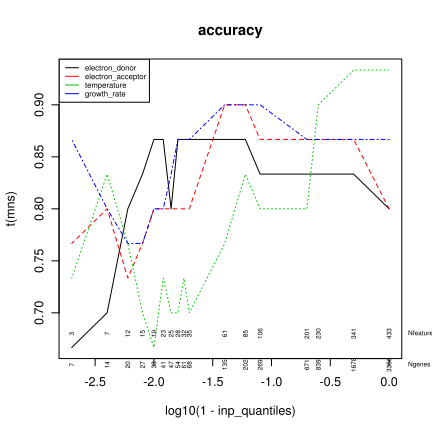

In [60]:
%%R
inp_quantiles <- c(0,0.5,0.75, seq(0.8,0.95,by=0.5),seq(0.92,0.98,by=0.02),seq(0.982,0.999,by=0.002))
mns <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)tmp2[[lev]]$predicted==unlist(tmp2[[lev]]$actual))))))
colnames(mns)<-names(qqq[[1]][[1]])
mns<-mns[,ncol(mns):1]
expr_levels = quantile(apply(x.ranks,1,median),inp_quantiles)
n_genes <- sapply(expr_levels,function(lev)sum(apply(x.ranks,1,median)>lev))

n_features <- sapply(1:length(inp_quantiles),function(lev)sapply(qqq,function(tmp1)mean(unlist(sapply(tmp1,function(tmp2)length(tmp2[[lev]]$features))))))
colnames(n_features)<-names(qqq[[1]][[1]])
n_features<-n_features[,ncol(n_features):1]

matplot(log10(1-inp_quantiles),t(mns),typ='l',main='accuracy') #, ylim=c(0.72,1))
legend('topleft',legend=rownames(mns),lwd=1,col=1:4, cex=0.6)
#text(log10(1-inp_quantiles), 0.5, lab=as.character(round(expr_levels)),cex=0.5,srt=90, xpd=NA)
#text(0.1, 0.5, lab='Rank', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.65, lab=as.character(n_genes),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.65, lab='Ngenes', pos=4, cex=0.5, xpd=NA)
text(log10(1-inp_quantiles), 0.68, lab=as.character(round(apply(n_features,2,mean))),cex=0.5,srt=90, xpd=NA)
text(0.1, 0.68, lab='Nfeatures', pos=4, cex=0.5, xpd=NA)

NULL

NULL


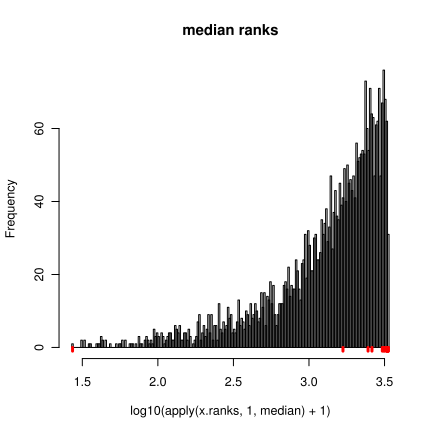

In [61]:
%%R
hist(log10(apply(x.ranks,1,median)+1),breaks=200,main='median ranks')
tmp<-sapply(expr_levels,function(i)lines(rep(log10(i+1),2),c(-1,0),col='red',lwd=3));rm(tmp);NULL